https://www.cnblogs.com/cocode/p/10183410.html  
https://www.jb51.net/article/167843.htm

In [11]:
%matplotlib inline
from torch import nn
from torch.nn import functional as F
from torchvision import datasets, transforms
import torch
import torchvision
import matplotlib.pyplot as plt

import torch.optim as optim

from torch.autograd import Variable


# 定义参数

In [73]:
class Config:
    batch_size = 64
    epoch = 10
    alpha = 1e-3
    print_per_step = 100  # 控制输出

# 定义网络

## 网络1

In [74]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 6, 5),  # 输入通道，输出通道，卷积核大小
            nn.Sigmoid(),
            nn.MaxPool2d(2,2),   # 卷积核大小，步幅
            nn.Conv2d(6,  16, 5),
            nn.Sigmoid(),
            nn.MaxPool2d(2,2)
        )
        self.fc = nn.Sequential(
            nn.Linear(16*4*4, 120),
            nn.Sigmoid(),
            nn.Linear(120, 84),
            nn.Sigmoid(),
            nn.Linear(84, 10)
        )
    
    def forward(self, img):
        feature = self.conv(img)
        output = self.fc(feature.view(img.shape[0], -1))
        return output
        

In [75]:
net = LeNet()
net

LeNet(
  (conv): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Sigmoid()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Sigmoid()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)

## 网络2

In [76]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)
        
    def forward(self, x):
        # 1*28*28 
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        y = self.fc3(out)
        return y

In [77]:
net = LeNet()
net

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## 查看网络每一层的结构

In [90]:
net = torch.nn.Sequential(
    # 1. 卷积
    nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2, stride=1),
    # 2. 池化
    nn.MaxPool2d(kernel_size=2, stride=2),
    # 3. 卷积
    nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0, stride=1),
    # 4. 池化
    nn.MaxPool2d(kernel_size=2, stride=2),
    # 5. 展开
    nn.Flatten(),
    # 6. 全连接
    nn.Linear(in_features=16*5*5, out_features=120),
    # 7. 全连接
    nn.Linear(in_features=120, out_features=84),
    # 8. 全连接
    nn.Linear(in_features=84, out_features=10)
)

'''
B x C x H x W
batch * channel * height * width
'''
X = torch.rand(1, 1, 28, 28)
for name, blk in net.named_children():
    X = blk(X)
    print(name,blk.__class__.__name__, 'output shape: ', X.shape)

0 Conv2d output shape:  torch.Size([1, 6, 28, 28])
1 MaxPool2d output shape:  torch.Size([1, 6, 14, 14])
2 Conv2d output shape:  torch.Size([1, 16, 10, 10])
3 MaxPool2d output shape:  torch.Size([1, 16, 5, 5])
4 Flatten output shape:  torch.Size([1, 400])
5 Linear output shape:  torch.Size([1, 120])
6 Linear output shape:  torch.Size([1, 84])
7 Linear output shape:  torch.Size([1, 10])


# 获取数据

## 获取数据

In [79]:
# 下载训练集
train_dataset = datasets.MNIST(root='./dataset/',
                train=True,
                transform=transforms.ToTensor(),
                download=True)
# 下载测试集
test_dataset = datasets.MNIST(root='./dataset/',
               train=False,
               transform=transforms.ToTensor(),
               download=True)



## 数据加载

In [84]:
'''
dataset: 指定数据集
batch_size: 每个批量中图片的个数
shuffle:  将数据进行打乱
'''

# 装载训练集
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=Config.batch_size,
    shuffle=True)

# 装载测试集
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=Config.batch_size,
    shuffle=True)

tensor([6, 0, 7, 3, 0, 9, 6, 6, 9, 0, 0, 0, 2, 3, 8, 6, 2, 1, 6, 5, 0, 8, 1, 0,
        0, 2, 0, 1, 2, 0, 8, 6, 3, 1, 9, 1, 0, 2, 4, 9, 1, 9, 7, 8, 7, 4, 6, 5,
        9, 7, 3, 1, 0, 5, 2, 1, 7, 5, 2, 0, 2, 8, 9, 6])


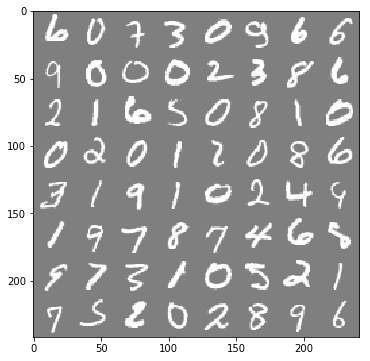

In [91]:
images, labels = next(iter(train_loader))
img = torchvision.utils.make_grid(images)

img = img.numpy().transpose(1, 2, 0)
std = [0.5, 0.5, 0.5]
mean = [0.5, 0.5, 0.5]
img = img * std + mean
print(labels)

plt.figure(figsize=(10,6))
plt.imshow(img)


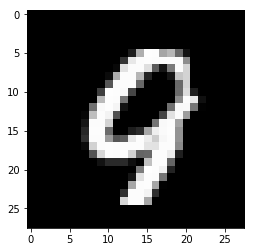

In [112]:
plt.imshow(images[0,:,:,:].reshape(28,28), cmap=plt.cm.gray)

In [110]:
images.shape

torch.Size([64, 1, 28, 28])

# 训练模型

In [82]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 64
LR = 0.001

net = LeNet().to(device)
# 损失函数使用交叉熵
criterion = nn.CrossEntropyLoss()

# 优化函数使用 Adam 自适应优化算法
optimizer = optim.Adam(
    net.parameters(),
    lr=LR,
)

epoch = 1
if __name__ == '__main__':
    for epoch in range(epoch):
        sum_loss = 0.0
        for i, data in enumerate(train_loader):
            inputs, labels = data
            inputs, labels = Variable(inputs).cuda(), Variable(labels).cuda()
            
            # 将梯度归零
            optimizer.zero_grad() 
            
            # 前向计算
            outputs = net(inputs) 
            
            # 计算损失
            loss = criterion(outputs, labels) 
            
            # 反向传播
            loss.backward() 
            
            # 更新梯度
            optimizer.step() 

            sum_loss += loss.item()
            if i % 100 == 99:
                print('[%d,%d] loss:%.03f' % (epoch + 1, i + 1, sum_loss / 100))
                sum_loss = 0.0

[1,100] loss:1.272
[1,200] loss:0.399
[1,300] loss:0.274
[1,400] loss:0.204
[1,500] loss:0.177
[1,600] loss:0.147
[1,700] loss:0.133
[1,800] loss:0.106
[1,900] loss:0.104


# 测试

In [87]:
# 将模型变换为测试模式
net.eval() 
correct = 0
total = 0
for data_test in test_loader:
    images, labels = data_test
    images, labels = Variable(images).cuda(), Variable(labels).cuda()
    output_test = net(images)
    _, predicted = torch.max(output_test, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
print("correct1: ", correct)
print("Test acc: {0}".format(correct.item() /
                 len(test_dataset)))

correct1:  tensor(9758, device='cuda:0')
Test acc: 0.9758
